In [23]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
import iisignature
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.metrics import mean_absolute_error

from tslearn.svm import TimeSeriesSVR
from sklearn.svm import SVR

import sigkernel

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return 100.*np.mean(np.abs((y_true - y_pred) / y_true)) 

In [7]:
#Helper function that extract rolling windows of historical prices of size h and means of the next future f prices.
def GetWindow(x, h_window=30, f_window=10):

    # First window
    X = np.array(x.iloc[:h_window,]).reshape(1,-1)
   
    # Append next window
    for i in range(1,len(x)-h_window+1):
        x_i = np.array(x.iloc[i:i+h_window,]).reshape(1,-1)
        X = np.append(X, x_i, axis=0)
        
    # Cut the end that we can't use to predict future price
    rolling_window = (pd.DataFrame(X)).iloc[:-f_window,]
    return rolling_window

def GetNextMean(x, h_window=30, f_window=10):
    return pd.DataFrame((x.rolling(f_window).mean().iloc[h_window+f_window-1:,]))

In [19]:
def PlotResult(y_train, y_test, y_train_predict, y_test_predict, name):
    
    train_len = len(y_train)
    test_len = len(y_test)
    
    #Visualise
    fig, ax = plt.subplots(1, figsize=(12, 5))
    ax.plot(y_train_predict,color='red')

    ax.plot(range(train_len, train_len+test_len),
            y_test_predict,
            label='Predicted average price',
            color='red',linestyle = '--')

    ax.plot(np.array((y_train).append(y_test)),
             label='Actual average price',
             color='green')

    ax.axvspan(len(y_train), len(y_train)+len(y_test),
                alpha=0.3, color='lightgrey')

    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best")
    plt.xlabel('Days')
    plt.ylabel('Bitcoin prices')
    plt.savefig('./pictures/bitcoin_prices_prediction_{}'.format(name))
    plt.show()

In [10]:
# load data (source is https://www.cryptodatadownload.com)
BTC_price = pd.read_csv('gemini_BTCUSD_day.csv',header=1)

# drop the first column and reverse order
BTC_price = BTC_price.iloc[1:,:]
BTC_price = BTC_price.iloc[::-1]
BTC_price['Date'] = pd.to_datetime(BTC_price['Date'])
BTC_price.set_index('Date', inplace=True)

# select duration
initial_date = '2017-06-01'
finish_date = '2018-08-01'
BTC_price = BTC_price.loc[BTC_price.index >= initial_date]
BTC_price = BTC_price.loc[BTC_price.index <= finish_date]

In [11]:
# use only close price
close_price = BTC_price.loc[:,'Close']
# close_price = TimeSeriesScalerMeanVariance().fit_transform(close_price.values[None,:])
close_price = pd.DataFrame(np.squeeze(close_price))

# use last h_window observations to predict mean over next f_window observations
h_window = 36
f_window = 2

# scaling
scale=1e-5

# next mean price
y = GetNextMean(close_price, h_window=h_window , f_window=f_window)

# normal window features
X_window = GetWindow(close_price, h_window, f_window).values
X_window = torch.tensor(X_window, dtype=torch.float64)
X_window = sigkernel.transform(X_window, at=True, ll=True, scale=scale)

# train test split
x_train, x_test, y_train, y_test = train_test_split(X_window, y, test_size=0.2, shuffle=False)
x_train = torch.tensor(x_train, dtype=torch.float64, device='cpu')
x_test = torch.tensor(x_test, dtype=torch.float64, device='cpu')

# Training phase

In [12]:
# hyperparameters for grid search
svr_parameters = {'C': np.logspace(0, 4, 5), 'gamma': np.logspace(-4, 4, 9)}

### signature PDE kernel

In [13]:
best_error = 1e8

for sigma in tqdm([5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 1.]):
    
    # Specify the static kernel 
    static_kernel = sigkernel.RBFKernel(sigma=sigma)

    # Initialize the corresponding signature kernel
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)
    
    # Gram matrix train
    G_train = signature_kernel.compute_Gram(x_train, x_train, sym=True).numpy()
    
    # fit the model
    svr = SVR(kernel='precomputed')
    svr_pde = GridSearchCV(estimator=svr, param_grid=svr_parameters, cv=5, n_jobs=-1)
    svr_pde.fit(G_train, np.squeeze(y_train))
            
    if np.abs(1.-svr_pde.best_score_) < np.abs(1.-best_error):
        best_pde_model = svr_pde
        best_error = svr_pde.best_score_
        best_sigma = sigma

  0%|          | 0/6 [00:00<?, ?it/s]

### truncated signature kernel 

In [20]:
best_error = 1e8
depths = [1, 2, 3, 4, 5, 6, 7, 8]

for d in tqdm(depths):
        
    # truncated signatures
    sig_train = iisignature.sig(x_train.numpy(), d)

    # normalization
    sig_train = sigkernel.normalize(sig_train, x_train.shape[-1], d)
    
    # fit the model
    svr = SVR(kernel='linear')
    svr_sig_model = GridSearchCV(estimator=svr, param_grid=svr_parameters, cv=5, n_jobs=-1)
    svr_sig_model.fit(sig_train, np.squeeze(y_train))
    
    # select best model
    if np.abs(1.-svr_sig_model.best_score_) < np.abs(1.-best_error):
        best_sig_model = svr_sig_model
        best_error = svr_sig_model.best_score_
        best_depth = d

  0%|          | 0/8 [00:00<?, ?it/s]

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


# Testing phase

In [24]:
# kernels to test
kernels = ['rbf', 'gak', 'sig', 'sig_PDE']

# store final results
final = {}

  0%|          | 0/3 [00:00<?, ?it/s]

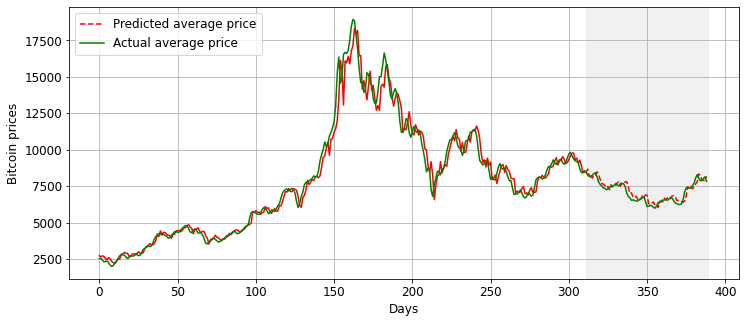

In [25]:
for ker in tqdm(kernels):

    if ker=='sig_PDE':
        
        # Specify the static kernel 
        static_kernel = sigkernel.RBFKernel(sigma=best_sigma)

        # Initialize the corresponding signature kernel
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=0)
    
        # Gram matrix test
        G_train = signature_kernel.compute_Gram(x_train, x_train, sym=True).numpy()
        G_test = signature_kernel.compute_Gram(x_test, x_train, sym=False).numpy()
        
        # predict
        y_train_predict = best_pde_model.predict(G_train)
        y_test_predict = best_pde_model.predict(G_test)  
        
        # calculate errors
        p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))
        final[ker] = p_error_test
        
        # plot results
        PlotResult(y_train, y_test, y_train_predict, y_test_predict, ker)
        
    elif ker in ['rbf', 'gak']:
        
        # fit 
        svr = TimeSeriesSVR(kernel=ker)
        svr_model = GridSearchCV(estimator=svr, param_grid=svr_parameters, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1)
        svr_model.fit(x_train.numpy(), np.squeeze(y_train))
        
        # predict
        y_train_predict = svr_model.predict(x_train.numpy())
        y_test_predict = svr_model.predict(x_test.numpy())
        
        # calculate errors
        p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), np.array(y_test_predict).reshape(-1,1))
        final[ker] = p_error_test

    else:            
        # truncated signatures
        sig_train = iisignature.sig(x_train.numpy(), best_depth)
        sig_test = iisignature.sig(x_test.numpy(), best_depth)

        # normalization
        sig_train = sigkernel.normalize(sig_train, x_train.shape[-1], best_depth)
        sig_test = sigkernel.normalize(sig_test, x_test.shape[-1], best_depth)

        # predict
        y_train_predict = best_sig_model.predict(sig_train)
        y_test_predict = best_sig_model.predict(sig_test)
            
        # calculate errors
        p_error_test = mean_absolute_percentage_error(np.array(y_test).reshape(-1,1), 
                                                      np.array(y_test_predict).reshape(-1,1))
        final[ker + f'_best_depth_{best_depth}'] = p_error_test

# save results
with open('./results/bitcoin_results.pkl', 'wb') as file:
    pickle.dump(final, file)

In [26]:
final

{'rbf': 4.094652105558635,
 'sig_PDE': 3.2531876957220742,
 'sig_best_depth_1': 13.420879507389571}

In [118]:
# print results
with open('./results/bitcoin_results.pkl', 'rb') as file:
    final = pickle.load(file)
    
print(final)

{'rbf': 8.939583538866353, 'gak': 6.9860291659170235, 'sig_PDE': 4.264447801086189, 'sig_best_depth_2': 12.788256906597544}
